## 0. Исходные данные, которые пригодятся для последующих расчетов

### 0.0. Подключим библиотеки и добавим вспомогательные функции

In [2]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

from scipy import stats
from scipy.stats import norm

# изменить формат вывода данных в pandas:
#pd.set_option('display.float_format', lambda x: '%.3f' % x) 

In [ ]:
def mode(array): # мода
  return stats.mode(array)[0][0]

In [ ]:
k0 = 100_000

def plot_distr(array):
  plt.figure(figsize=(8, 4)); 
  plt.subplot(121)
  plt.plot(array)
  plt.subplot(122)
  plt.hist(array, bins=20);

def plot_norm(mu=0, sigma=1, t=3):
  x = np.linspace(mu - t * sigma, mu + t * sigma, 100)
  y = stats.norm.pdf(x, mu, sigma)
  plt.plot(x, y, label='mu=%.3f, d2=%.3f' % (mu, sigma)); plt.title('Norm'); plt.legend()

def plot_student(df, mu=0, sigma=1, t=3):
  x = np.linspace(mu - t * sigma, mu + t * sigma, 100)
  y = stats.t.pdf(x, df, mu, sigma) 
  plt.plot(x, y, label='df=%d, mu=%.3f, sigma=%.3f' % (df, mu, sigma)); plt.title('Student'); plt.legend()

def plot_fisher(dfn, dfd):
  x = np.linspace(0, 4, 100)
  y = stats.f.pdf(x, dfn, dfd) # x, dfn, dfd
  plt.plot(x, y, label='d1=%d, d2=%d' % (dfn, dfd))
  plt.title('Fisher'); plt.legend();

In [ ]:
from sklearn.linear_model import LinearRegression
from types import ModuleType

def plot_corr(x, y, x_label='x', y_label='y', plot=plt):
  plot.scatter(x, y, c='k')
  plot.plot([x.mean()]*2, [y.min(), y.max()], '--r', label='$\overline{%s}$' % x_label)
  plot.plot([x.min(), x.max()], [y.mean()]*2, '--b', label='$\overline{%s}$' % y_label)

  lr = LinearRegression().fit(x.reshape((-1, 1)), y)
  r, p_value = stats.pearsonr(x, y) # можно через stats
  #r2 = lr.score(x2.reshape((-1, 1)), y2) # можно через sklearn
  x_th = np.array([x.min(), x.max()])
  y_th = lr.predict(x_th.reshape((-1, 1)))
  #y_th = lr.intercept_ + lr.coef_[0] * # x_th тоже самое
  plot.plot(x_th, y_th, label='%.3f + %.3fx' % (lr.intercept_, lr.coef_))
  if isinstance(plot, ModuleType):
    plot.xlabel(x_label); plot.ylabel(y_label)
    plot.title('r = %.3f, p_value = %.3f' % (r, p_value));
  else:
    plot.set_xlabel(x_label); plot.set_ylabel(y_label)  
    plot.set_title('r = %.3f, p_value = %.3f' % (r, p_value));
  plot.legend()


def plot_full_corr(x, y, x_label='x', y_label='y', residuals_by_y=True):
  '''
  Compute correlation; plot data and regression line; 
  plot residuals; plot histogram and normal Q-Q plot of residuals.
  '''
  fig = plt.figure(figsize=(12,8))
  ax11 = fig.add_subplot(2, 1, 1)
  ax21 = fig.add_subplot(2, 3, 4)
  ax22 = fig.add_subplot(2, 3, 5)
  ax23 = fig.add_subplot(2, 3, 6)
  fig.subplots_adjust(wspace=.3, hspace=.3)

  ax11.scatter(x, y, c='k')
  ax11.plot([x.mean()]*2, [y.min(), y.max()], '--r', label='$\overline{%s}$' % x_label)
  ax11.plot([x.min(), x.max()], [y.mean()]*2, '--b', label='$\overline{%s}$' % y_label)

  lr = LinearRegression().fit(x.reshape((-1, 1)), y)
  r, p_value = stats.pearsonr(x, y)
  x_th = np.array([x.min(), x.max()])
  y_th = lr.predict(x_th.reshape((-1, 1)))
  ax11.plot(x_th, y_th, label='$\hat y$ = %.3f + %.3fx' % (lr.intercept_, lr.coef_))
  ax11.set_xlabel(x_label); ax11.set_ylabel(y_label)  
  ax11.set_title('Регрессионная модель\nr = %.3f, p_value = %.3f' % (r, p_value))
  ax11.legend()

  y_pred = LinearRegression().fit(x.reshape((-1, 1)), y).predict(x.reshape((-1,1)))
  e = y - y_pred
  
  if residuals_by_y:
    res_x = y_pred
    res_x_label = y_label
  else:
    res_x = x
    res_x_label = x_label
  ax21.scatter(res_x, e)
  ax21.plot([res_x.min(), res_x.max()], [0,0], 'k')
  ax21.set_title('Распределение остатков')
  ax21.set_xlabel('Предсказанные значения ' + res_x_label)
  ax21.set_ylabel('Остатки')  

  ax22.hist(e, bins=20); ax22.set_title('Гистограмма остатков'); ax22.set_xlabel('Остатки'); ax22.set_ylabel('Плотность')  
  stats.probplot(e, dist="norm", plot=ax23); ax23.set_title('Q-Q Plot остатков'); 

In [3]:
def mean_confidence_interval(x_m, sd, n, p):
  se = sd / np.sqrt(n)
  t = norm.ppf((1+p)/2)
  left = x_m - t * se
  right = x_m + t * se
  print('С вероятностью  %.3f, M находится в этом интервале:' % p)
  print((left, right))
  return left, right
  
def p_value_student(t, df, both=True):
  k = 2 if both else 1
  return stats.t.sf(np.abs(t), df) * k

def p_value_norm(z, both=True):
  k = 2 if both else 1
  return stats.norm.sf(np.abs(z)) * k

In [ ]:
def calc_rsquared_adj(model, data):
  print(model, end=': r2_adj = ')
  rsquared_adj = smf.ols(model, data=data).fit().rsquared_adj
  print(round(rsquared_adj, 4))
  return rsquared_adj 

### 0.1. Равномерное распределение

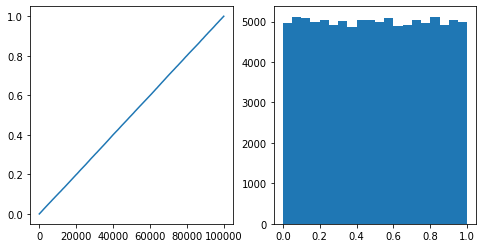

In [ ]:
ravn = np.random.rand(k0); ravn.sort()
plot_distr(ravn)

### 0.2. Нормальное распределение

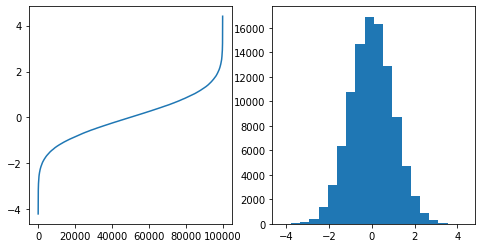

In [ ]:
normal = np.random.randn(k0); normal.sort()
plot_distr(normal)

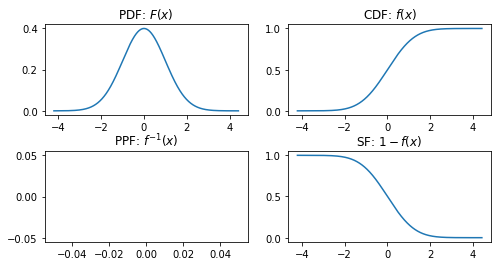

In [ ]:
from scipy.stats import norm
plt.figure(figsize=(8, 4))
plt.subplot(221)
plt.subplots_adjust(hspace=0.4) #hspace=0, 
plt.plot(normal, norm.pdf(normal)); plt.title('PDF: $F(x)$')
plt.subplot(222)
plt.plot(normal, norm.cdf(normal)); plt.title('CDF: $f(x)$')
plt.subplot(223)
plt.plot(0); plt.title('PPF: $f^{-1}(x)$')
plt.subplot(224)
plt.plot(normal, norm.sf(normal)); plt.title('SF: $1-f(x)$');

### 0.3. Синтетический датафрэйм "age-sex-rayon"

In [ ]:
print('Сделаем рандомную выборку возраста и пола')
print('При этом женщины в среднем старше мужчин на 10 лет:')
np.random.seed(1)
age = np.random.randint(18, 66, k0)
sex = np.random.choice(['M', 'F'], k0)
rayon = np.random.choice(['Adm', 'Nev', 'Cen', 'Kal', 'Vas'], k0)
age_sex = pd.DataFrame({'age':age, 'sex':sex, 'rayon': rayon})
age_sex.loc[age_sex['sex'] == 'F', 'age'] = age_sex['age'] + 10
age_sex.head()

Сделаем рандомную выборку возраста и пола
При этом женщины в среднем старше мужчин на 10 лет:


,age,sex,rayon
0,65,F,Cen
1,71,F,Adm
2,30,M,Vas
3,36,F,Nev
4,37,F,Cen


In [ ]:
print('Проверим средний возраст:')
age_sex.groupby('sex').describe()

Проверим средний возраст:


age                                                 
        count   mean    std    min    25%    50%    75%    max
sex                                                           
F   50005.000 51.467 13.840 28.000 39.000 51.000 64.000 75.000
M   49995.000 41.472 13.821 18.000 30.000 41.000 53.000 65.000

### 0.4. Кластеры

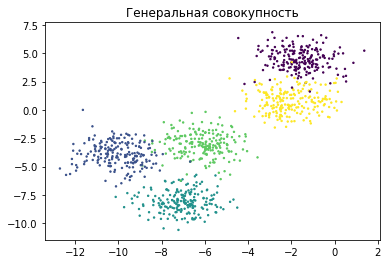

In [ ]:
# Генеральная совокупность
from sklearn.datasets import make_blobs

n0, n = 1000, 30
X, y = make_blobs(n_samples=n0, centers=5, random_state=1)
plt.scatter(X[:,0], X[:,1], c=y, s=2); plt.title('Генеральная совокупность')

def plot_sample(X, y, X_sample, title):
  plt.scatter(X[:,0], X[:,1], c=y, s=2)
  plt.scatter(X_sample[:,0], X_sample[:,1], c='red')
  plt.title(title);

## 1. Введение

### 1.1 Общая информация о курсе
[Основы статистики](https://stepik.org/course/76/promo)

### 1.2. Выборка и генеральная совокупность

#### Simple random sample - Случайная выборка

Выбираем элементы генеральной совокупности случайно

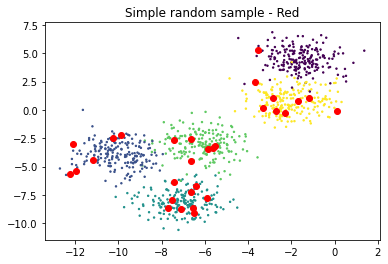

In [ ]:
np.random.seed(0)
k = 1000 # n=30
random_sample_X = X[np.random.choice(k, n, replace=False)] # выбираем 30 из 1000
plot_sample(X, y, random_sample_X, 'Simple random sample - Red')

In [ ]:
# DataFrame
simple_sample_random_age_sex, _ = train_test_split(age_sex, train_size = k/k0)
print('Проверим средний возраст для выборки:')
print('Пропорция почти соблюдена, возраст отличается также на почти 10 лет')
simple_sample_random_age_sex.groupby('sex').describe()

Проверим средний возраст для выборки:
Пропорция почти соблюдена, возраст отличается также на почти 10 лет


age                                                 
      count   mean    std    min    25%    50%    75%    max
sex                                                         
F   500.000 51.480 14.042 28.000 39.000 51.000 64.000 75.000
M   500.000 41.420 14.179 18.000 29.750 40.000 54.000 65.000

#### Stratified sample - Стратифицированная выборка

1. Разбивка на страты (по каким-либо показателям: возраст, пол и т.д.)
2. Выбираем случайно из каждой такой страты данные

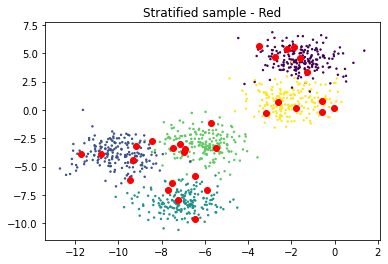

In [ ]:
np.random.seed(0)
stratified_sample_X, _ = train_test_split(X, train_size = n/n0, stratify=y)
plot_sample(X, y, stratified_sample_X, 'Stratified sample - Red')

In [ ]:
print('Stratified sample', end='\n\n')
stratified_sample_age_sex, _ = train_test_split(age_sex, train_size = k/k0, stratify=age_sex['sex'])
print('Проверим средний возраст для выборки:')
print('Пропорция соблюдена, возраст отличается также на почти 10 лет')
stratified_sample_age_sex.groupby('sex').describe()

Stratified sample

Проверим средний возраст для выборки:
Пропорция соблюдена, возраст отличается также на почти 10 лет


age                                                 
      count   mean    std    min    25%    50%    75%    max
sex                                                         
F   500.000 51.746 14.254 28.000 40.000 52.000 64.250 75.000
M   500.000 41.124 13.858 18.000 29.000 42.000 52.250 65.000

#### Cluster sample - Групповая выборка

Выбираем лишь определенные группы и из них берем данные случайным образом

Групповая выборка


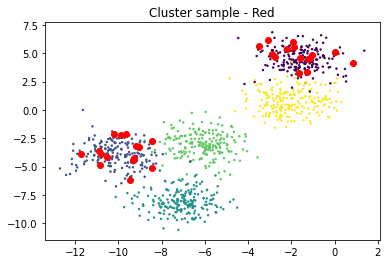

In [ ]:
print('Групповая выборка')
# возьмем только первые два кластера:
np.random.seed(0)
clusters1_idx = np.where(y == 0)[0]
clusters1_idx = np.random.choice(clusters1_idx, int(n/2), replace=False)
clusters2_idx = np.where(y == 1)[0]
clusters2_idx = np.random.choice(clusters2_idx, int(n/2), replace=False)
clusters_idx = np.concatenate((clusters1_idx, clusters2_idx))

cluster_sample_X = X[clusters_idx]

plot_sample(X, y, cluster_sample_X, 'Cluster sample - Red')

### 1.3. Типы переменных


*   Количественные
  1.   Непрерывные (рост)
  2.   Дискретные (кол-во детей)
  
*   Номинативные (качественные)
  1.   (1-Ж, 2-М: 1 !< 2)
  2.   Ранговые (место в марафоне: 1 место < 5 места)

In [ ]:
# конвертация из количественной дискретной в номинативный ранговый
# нехороший способ с точки зрения реализации
age_sex.loc[age_sex['age'] < 35, 'age_rank'] = 'young'
age_sex.loc[(age_sex['age'] > 34) & (age_sex['age'] < 60), 'age_rank'] = 'middle'
age_sex.loc[age_sex['age'] > 59, 'age_rank'] = 'old'

NameError: ignored

In [ ]:
# быстрый способ
age_sex['age_rank2'] = pd.cut(age_sex['age'], bins=[17,34,59,75], labels=[0,1,2])
age_sex.head()

,age,sex,rayon,age_rank,age_rank2
0,65,F,Cen,old,2
1,71,F,Adm,old,2
2,30,M,Vas,young,0
3,36,F,Nev,middle,1
4,37,F,Cen,middle,1


### 1.4. Меры центральной тенденции

In [ ]:
array_m = age_sex[age_sex['sex']=='M']['age']
array_f = age_sex[age_sex['sex']=='F']['age']
array_mf = age_sex['age']

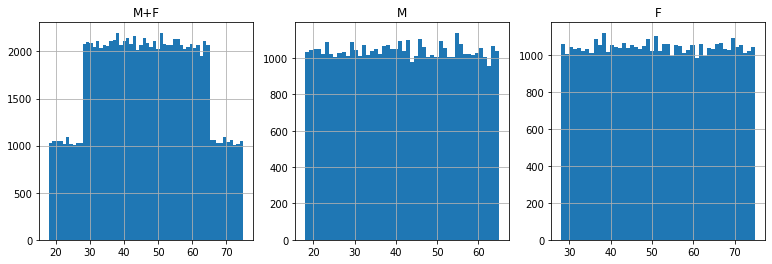

In [ ]:
plt.figure(figsize=(13, 4)); plt.subplot(131)
array_mf.hist(bins=66-18+10); plt.title('M+F')
plt.subplot(132)
array_m.hist(bins=66-18); plt.title('M')
plt.subplot(133)
array_f.hist(bins=66-18); plt.title('F'); 
#for i in range(66-18):
#    plt.text(arr[1][i],arr[0][i],str(arr[0][i])) # show counts over the bar

In [ ]:
print('Медиана для М - %.1f, F - %.1f и всех - %.1f' %
      (np.median(array_m), np.median(array_f), np.median(array_mf)))
print() # cовпадает с гистрограммой

print('Среднее для М - %.2f, F - %.2f и всех - %.2f' %
      (np.mean(array_m), np.mean(array_f), np.mean(array_mf)))
print() # также совпадает с гистрограммой и близко к медиане - выбросов нет

print('Мода для М - %d, F - %d и всех - %d' %
      (mode(array_mf), mode(array_f), mode(array_mf))) # scipy.stats.mode(array)[0][0]

scipy.stats.mode(age_sex['age']) # соотносится с гистрограммой значение и кол-во
# мода не близка к медиане и среднему - т.к. равномерное распределение

Медиана для М - 41.0, F - 51.0 и всех - 46.0

Среднее для М - 41.47, F - 51.47 и всех - 46.47

Мода для М - 51, F - 38 и всех - 51


ModeResult(mode=array([51]), count=array([2199]))

**Мода** - значение определяемого признака, которое встречается максимально часто. *Данных значений у выборки может быть несколько!*

**Медиана** - значение признака, которое делит упорядоченное множество данных пополам. *Если это значение находится между двумя значениями ряда, то берется полусумма их значений.*

**Среднее значение $\overline{X}$** - сумма всех значений измеренного признака, деленная на количество измеренных значений. *Символ "M(X)" - используется для генеральной совокупности.*

**POT-PLOT**<br>
Моду визуально легко определить по POT-PLOT, не нашел реализации в python :( <br>
Мода - 172; Среднее значение - 170,4; Медиана - (170+171)/2=170.5
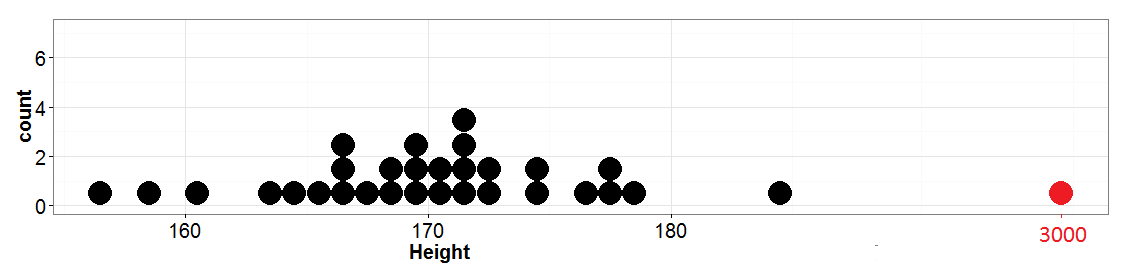

Распределение - симметрично, унимодально, нет выбросов - можно использовать любую меру центральной тенденции

Иначе - среднее значение может ввести нас в заблуждение

In [ ]:
C=10
print('C =', C)
print('M(x+C)=Mx+C: %.3f = %.3f + %d' % (np.mean(array_mf+C), np.mean(array_mf), C))
print('M(x*C)=Mx*C: %.3f = %.3f * %d' % (np.mean(array_mf*C), np.mean(array_mf), C))
dev = array_mf - np.mean(array_mf)
print('sum(xi-Mx) = %.5f' % np.sum(dev))

C = 10
M(x+C)=Mx+C: 56.470 = 46.470 + 10
M(x*C)=Mx*C: 464.700 = 46.470 * 10
sum(xi-Mx) = -0.00000


### 1.5. Меры изменчивости


**Размах** - разность максимального и минимального значения

In [ ]:
print('''max - min, не зависит от остальных значений - плохо
scipy.ptp(array_mf) - тоже самое, что и np.ptp
DeprecationWarning: scipy.ptp is deprecated and will be removed in SciPy 2.0.0, use numpy.ptp instead
''')
np.ptp(array_mf), array_mf.max() - array_mf.min()

max - min, не зависит от остальных значений - плохо
scipy.ptp(array_mf) - тоже самое, что и np.ptp



(57, 57)

**Дисперсия** - средний квадрат отклонений индивидуальных значений признака от их средней величины

$D = \frac {\sum (x_i-\overline{x})} n$ (ген. совокуп.)

$D = \frac {\sum (x_i-\overline{x})} {n-1}$ (для выборки)

$\sigma = \sqrt D$ - ген. совокупность

sd = $\sqrt D$ - выборка

In [ ]:
# Дисперсия, нормальное распределение
normal_sample = np.random.choice(normal, k, replace=False) # replace=False - без повторов
print('Генеральная совокуп k = %d:' % k0)
print('m = %.2f, std = %.2f, где'
            % (normal.mean(), normal.std(ddof=0)), end='\n\n')

print('Выборка k = %d:' % k)
print('m = %.2f, sd = %.2f' 
            % (normal_sample.mean(), normal_sample.std(ddof=1))) 
print('m - mean, std - standard deviation, sd - squared deviation')
print('ddof=0 - для ген. совокуп., 1 - для выборки из-за потери степени свободы (поиск среднего)')
print('std - ген. совокуп., sd - выборка')

Генеральная совокуп k = 100000:
m = 0.01, std = 1.00, где

Выборка k = 1000:
m = 0.01, sd = 0.99
m - mean, std - standard deviation, sd - squared deviation
ddof=0 - для ген. совокуп., 1 - для выборки из-за потери степени свободы (поиск среднего)
std - ген. совокуп., sd - выборка


In [ ]:
print('C =', C)
print('D(x+C)=Dx:  %.3f = %.3f' % (np.std(array_mf)**2, np.std(array_mf+C)**2))
print('D(x*C)=Dx*C^2: %.3f = %.3f * %d^2' % (np.std(array_mf*C)**2, np.std(array_mf)**2, C))
print()
print('sd(x+C)=sdx: %.3f = %.3f' % (np.std(array_mf), np.std(array_mf+C)))
print('sd(x*C)=sdx*C: %.3f = %.3f * %d' % (np.std(array_mf*C), np.std(array_mf), C))

C = 10
D(x+C)=Dx:  216.264 = 216.264
D(x*C)=Dx*C^2: 21626.432 = 216.264 * 10^2

sd(x+C)=sdx: 14.706 = 14.706
sd(x*C)=sdx*C: 147.059 = 14.706 * 10


### 1.6. Квартили распределения и box-plot

Квартили - 3 точки, делят выборку на 4 равныи части <br>
Межквартильный размах - IQR = Q3 - Q1 <br>
Медиана = второй квартиль (Q2) <br>
**Box-plot - Яшик с усами**

In [ ]:
median = np.percentile(normal_sample, 50) # через процентиль, либо np.median
q1, q2, q3 = np.percentile(normal_sample, [25, 50, 75])
iqr = q3 - q1 # iqr == scipy.stats.iqr(normal_sample) ? : True
print('q1 = %.1f, q2 = %.1f, q3 = %.1f, IQR = %.1f' % (q1, q2, q3, iqr))

q1 = -0.7, q2 = 0.1, q3 = 0.7, IQR = 1.3


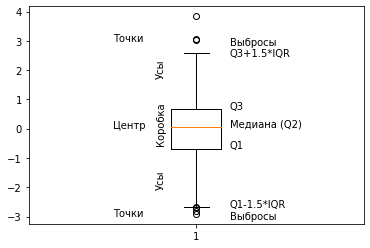

In [ ]:
plt.boxplot(normal_sample)
# ТОЛЬКО plt.text далее:
plt.text(1.1, q2, 'Медиана (Q2)', rotation = 0, fontsize = 10)
plt.text(1.1, q1, 'Q1', rotation = 0, fontsize = 10)
plt.text(1.1, q3, 'Q3', rotation = 0, fontsize = 10)
plt.text(1.1, q1-1.5*iqr, 'Q1-1.5*IQR', rotation = 0, fontsize = 10)
plt.text(1.1, q3+1.5*iqr-.2, 'Q3+1.5*IQR', rotation = 0, fontsize = 10)
plt.text(1.1, q1-1.5*iqr-.4, 'Выбросы', rotation = 0, fontsize = 10)
plt.text(1.1, q3+1.5*iqr+.2, 'Выбросы', rotation = 0, fontsize = 10)
plt.text(0.75, 0, 'Центр', rotation = 0, fontsize = 10)
plt.text(0.88, -.5, 'Коробка', rotation = 90, fontsize = 10)
plt.text(0.88, -2, 'Усы', rotation = 90, fontsize = 10)
plt.text(0.88, 1.8, 'Усы', rotation = 90, fontsize = 10)
plt.text(0.75, 3, 'Точки', rotation = 0, fontsize = 10)
plt.text(0.75, -3, 'Точки', rotation = 0, fontsize = 10);

### 1.7. Нормальное распределение

*   Унимодально
*   Симметрично
В реальном мире многое распределено нормально.





In [ ]:
hist = np.histogram(normal, bins=50)
x_hist, y_hist = hist[1][1:], hist[0] 

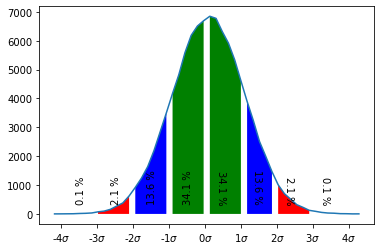

In [ ]:
int31 = np.where(((x_hist >= -3) & (x_hist <= -2))) # int - interval
int21 = np.where(((x_hist >= -2) & (x_hist <= -1)))
int11 = np.where((x_hist >= -1) & (x_hist <= 0))
int12 = np.where((x_hist >= 0) & (x_hist <= 1))
int22 = np.where(((x_hist >= 1) & (x_hist <= 2)))
int32 = np.where(((x_hist >= 2) & (x_hist <= 3)))

plt.plot(x_hist, y_hist)
plt.fill_between(x_hist[int31], 0, y_hist[int31], facecolor='r')
plt.fill_between(x_hist[int21], 0, y_hist[int21], facecolor='b')
plt.fill_between(x_hist[int11], 0, y_hist[int11], facecolor='g')
plt.fill_between(x_hist[int12], 0, y_hist[int12], facecolor='g')
plt.fill_between(x_hist[int22], 0, y_hist[int22], facecolor='b')
plt.fill_between(x_hist[int32], 0, y_hist[int32], facecolor='r')
plt.text(-3.6, 400, '0.1 %', rotation = 90, fontsize = 10)
plt.text(-2.6, 400, '2.1 %', rotation = 90, fontsize = 10)
plt.text(-1.6, 400, '13.6 %', rotation = 90, fontsize = 10)
plt.text(-0.6, 400, '34.1 %', rotation = 90, fontsize = 10)
plt.text(0.3, 400, '34.1 %', rotation = 270, fontsize = 10)
plt.text(1.3, 400, '13.6 %', rotation = 270, fontsize = 10)
plt.text(2.2, 400, '2.1 %', rotation = 270, fontsize = 10)
plt.text(3.2, 400, '0.1 %', rotation = 270, fontsize = 10)
x_ticks = np.arange(-4, 5)
x_labels = np.core.defchararray.add(x_ticks.astype('str'), '$\sigma$')
plt.xticks(x_ticks, x_labels, rotation=0);

Стандартизация или z-преобразование - преобразование полученных данных в стандартную Z-шкалу (Z-scores) со средним $M_Z=0$ и $D_Z = 1$

$Z_i = \frac {X_i - \overline X} {sd_X} $

$ \overline X - C = \overline X - \overline X = 0$

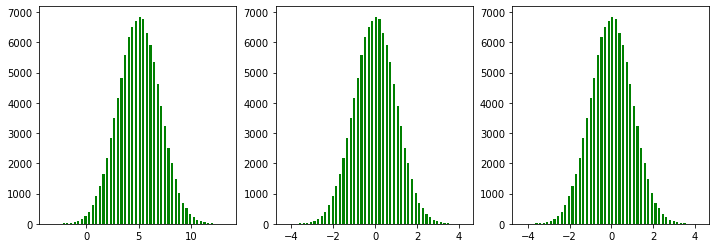

In [ ]:
normal_scaled_biased = normal * 2 + 5
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hist(normal_scaled_biased, bins=50, density=False, histtype='bar', rwidth=0.6, color='g');
plt.title('Normal scaled and biased')

# Z-стандартизация: m = 0 , sd = 1
# вручную
plt.subplot(132)
normal_scaled_biased_z = (normal_scaled_biased - normal_scaled_biased.mean()) / normal_scaled_biased.std()
plt.hist(normal_scaled_biased_z, bins=50, density=False, histtype='bar', rwidth=0.6, color='g');
plt.title('Z-standartisation manual')

# Z-стандартизация: m = 0 , sd = 1
# автоматически - sklearn
plt.subplot(133)

from sklearn.preprocessing import StandardScaler
normal_scaled_biased_z = StandardScaler().fit_transform(np.expand_dims(normal_scaled_biased, axis=1))
plt.hist(normal_scaled_biased_z, bins=50, density=False, histtype='bar', rwidth=0.6, color='g')
plt.title('Z-standartisation automated');

**Задача**<br>
Допустим, мы измерили рост 1000 человек, данное распределение оказалось нормальным со средним равным 175 и стандартным отклонением равным 8 (M = 175, sd = 8). Рост одного из испытуемых составил 186,2. Чему равняется z - значение, рассчитанное для этого испытуемого?

**Ответ: 1.4**

In [ ]:
a_mean, a_sd, n  = 175, 8, 1000
a_i = 186.2
(a_i-a_mean)/a_sd, 2

(1.3999999999999986, 2)

In [ ]:
print('Создадим такую выборку, что: N(mu,sigma) = N(175, 8)')
a = np.random.randn(n); a = a.reshape(-1, 1) # выборка из 1000 измерений
a = StandardScaler().fit_transform(a) # zet-преобразование 
a = a * a_sd + a_mean # M = 175, sd = 8
b = StandardScaler().fit(a) # zet-преобразование еще раз
b.transform(np.array([[a_i]]))[0][0] # ответ

Создадим выборку, таку что: N(mu,sigma) = N(175, 8)


1.3999999999999988

**Задача**<br>
Допустим, что некоторый признак распределен нормально, выборочное среднее равняется 100, а дисперсия равняется 25 (M = 100, D = 25). Тогда приблизительно 95% всех наблюдений находится в диапазоне: <br>
**Ответ: от 90 до 110**

In [ ]:
m, d, p = 100, 25, 0.95
print('N(mu, D) = N(100, 25)')
print(m - np.sqrt(d) * 2, m + np.sqrt(d) * 2)

N(mu, D) = N(100, 25)
90.0 110.0


**Задача**<br>
Считается, что значение IQ (уровень интеллекта) у людей имеет нормальное распределение со средним значением равным 100 и стандартным отклонением равным 15 (M = 100, sd = 15).

Какой приблизительно процент людей обладает IQ  на промежутке от 70 до 112 

**Ответ: 77 %**

In [ ]:
m, sd = 100, 15
a, b = 70, 112
z_a = (a-m) / sd 
z_b = (b-m) / sd 
z_a, z_b

round((norm.cdf(z_b) - norm.cdf(z_a)) * 100) # loc=0, scale=1

77.0

### 1.8. Центральная предельная теорема (ЦПТ) - Central limit theorem (CLT)

Стандартная ошибка среднего:

$se = \frac \sigma {\sqrt n} = \frac {sd_X} {\sqrt n}$, последнее верно при $n \gtrapprox 30$

Mean = 0.01, SE = 0.03
Для ген. совокуп.: M = 0.01, std = 1.00
se = std / sqrt(n): 0.03 : 1.00 / 31.6 = 0.03


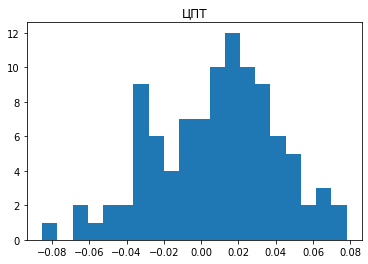

In [ ]:
clt = np.array([np.random.choice(normal,  1000, replace=False).mean() for _ in range(100)])
plt.hist(clt, bins=20); plt.title('ЦПТ')
print('Mean = %.2f, SE = %.2f' % (clt.mean(), clt.std()))
print('Для ген. совокуп.: M = %.2f, std = %.2f' % (normal.mean(), normal.std()))
print('se = std / sqrt(n): %.2f : %.2f / %.1f = %.2f' % (clt.std(), normal.std(), 1000 ** 0.5, norm.std() / 1000 ** 0.5))

se = sd / sqrt(n) = 1.02 / sqrt(1000) = 0.03


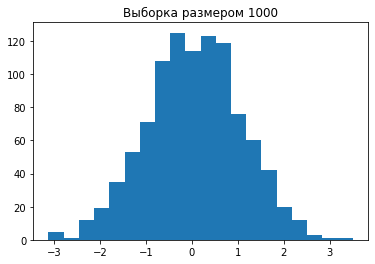

In [ ]:
a = np.random.choice(normal,  1000, replace=False)
plt.hist(a, bins = 20); plt.title('Выборка размером 1000')
print('se = sd / sqrt(n) = %.2f / sqrt(1000) = %.2f' % (a.std(), a.std()/1000**0.5))

**Задача**

Рассчитайте стандартную ошибку среднего, если выборочное среднее равняется 10, дисперсия 4, при N = 100

**Ответ: 0.2**

In [ ]:
m, d, n = 10, 4, 100
se = np.sqrt(d / n); se

0.2

### 1.9. Доверительные интервалы для среднего

M $\pm$ t * se $\approx$ M $\pm$ 2 * se

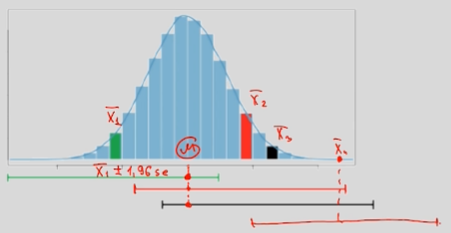

$\overline{X}$ = 100, sd = 4, n = 64 <br>
$\overline{X}$ $\pm$ 2 * se - ?

In [ ]:
x_m, sd, n = 100, 4, 64
se = sd / np.sqrt(n); se

0.5

In [ ]:
# 100 +- 2 * 0.5
left = x_m - 2 * se
right = x_m + 2 * se
print('Мы на 95 % уверены, что M находится в этом интервале:')
left, right

Мы на 95 % уверены, что M находится в этом интервале:


(99.0, 101.0)

Рассчитайте 99% доверительный интервал для следующего примера:
$\bar{x}$=10; sd=5; n=100

In [ ]:
'''def mean_confidence_interval(x_m, sd, n, p):
  se = sd / np.sqrt(n)
  t = norm.ppf((1+p)/2)
  return and print((left, right)) = x_m +- t * se '''

mean_confidence_interval(10, 5, 100, 0.99); #

С вероятностью  0.990, M находится в этом интервале:
(8.71208534822555, 11.28791465177445)


### 1.10 Идея статистического вывода, p-уровень значимости

Ген. совокупность. кол-во дней для выздоровления: 20 <BR>
Использовали препарат на 64 чел. дней стало - 18,5 <BR>
Стало лучше? <BR>
H0: M = 20 <BR>
H1: M $\neq$ 20

In [ ]:
M, n, x_mean, sd = 20, 64, 18.5, 4

# Допустим H0 верно
se = sd / np.sqrt(n); print('se =', se)
z = (x_mean - M) / se; print('z =', z)
print('p = %.3f' % (norm.cdf(z)*2), end='') # *2 - по обе стороны
print(' < 0.05 - отклоняем H0')

se = 0.5
z = -3.0
p = 0.003 < 0.05 - отклоняем H0


Обычно принимается порог отклонения нулевой гипотезы - 0.05

**Ошибки первого и второго рода**

Ошибка 1-го рода - отклонение нулевой гипотезы, хотя она верна

Ошибка 2-го рода - не отклонение нулевой гипотезы, хотя верна альтернативная (более печальная ситуация)

Если в определенной ситуации весьма рискованно отклонить нулевую гипотезу, когда она на самом деле верна, то лучше использовать показатель $\alpha$ равный:<br>
**0.001**<br>
0.5 <br>
0.05 <br>
0.1

Использование доверительных интервалов зачастую рассматривают, как альтернативный способ проверки гипотез. В нашем случае, если значение 20 (предполагаемое среднее значение в генеральной совокупности) не будет принадлежать 95% доверительному интервалу, рассчитанному по выборочным данным, у нас будет достаточно оснований отклонить нулевую гипотезу. Проверьте согласуются ли результаты двух этих подходов: рассчитайте 95% доверительный интервал для среднего значения, на примере с тестированием нового препарата.

In [ ]:
mean_confidence_interval(18.5, 4, 64, 0.95); print()
mean_confidence_interval(18.5, 4, 64, 0.99); print()
print('20 не принадлежит доверительному интервалу — отклоняем Н0')

С вероятностью  0.950, M находится в этом интервале:
(17.520018007729973, 19.479981992270027)

С вероятностью  0.990, M находится в этом интервале:
(17.21208534822555, 19.78791465177445)

20 не принадлежит доверительному интервалу — отклоняем Н0


Данные некоторого исследования сообщают нам, что средний рост детей в 10 лет составляет 136 сантиметров. Однако это лишь выборочная оценка, и исследователи рассчитали 99% доверительный интервал, который составил [130, 142]. Укажите верные утверждения:


*   Доверительный интервал не может иметь такие границы, т. к. выборочное стандартное отклонение равняется 10, следовательно доверительный интервал должен быть значительно шире.
*   Вероятность того, что истинное среднее значение больше 142, составляет 0,01
*   **У нас достаточно оснований отклонить нулевую гипотезу, что среднее в генеральной совокупности равняется 143**
*   **У нас достаточно оснований отклонить нулевую гипотезу, что среднее в генеральной совокупности равняется 128.**

In [ ]:
x_mean, p = 136, 0.99
left, right = 130, 142

t = norm.ppf((1+p)/2)
se = (right - x_mean) / t
t, se

(2.5758293035489004, 2.329346898776786)

В среднем слушатели курса по введению в статистику набирают 115 баллов, однако, в 2015 году средний балл  случайно выбранных 144 участников составил 118 со стандартным отклонением равным 9. Рассчитайте p уровень значимости для проверки нулевой гипотезы о том, что среднее значение баллов в 2015 году равняется 115.

**p < 0,05 - отклоняем нулевую гипотезу**

In [ ]:
m = 115
x_mean, n, sd = 118, 144, 9
se = sd / np.sqrt(n)
z = (x_mean - m) / se
p = norm.sf(z) * 2
p

6.334248366623973e-05

## 2.  Сравнение средних

### 2.1. T-распределение

Если наблюдений невелико (например < 30) и сигма неизвестна (почти всегда) <br>
Число степеней свободы: df = n - 1

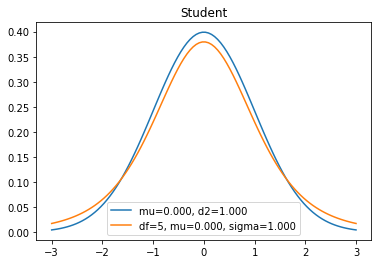

In [ ]:
plot_norm() # y = stats.norm.pdf(x=[-3...3], mu=0, sigma=1)
plot_student(5) # y = stats.t.pdf(x=[-3...3], df=5, mu=0, sigma=1) 

In [ ]:
m = 10
x_mean, sd, n = 10.8, 2, 25
se = sd / np.sqrt(n); se
z = (x_mean - m) / se
# p < 0.05
p = norm.sf(z) * 2; p

0.0455002638963582

z = $\frac{\overline{X}-\mu}{\frac{\sigma}{\sqrt{n}}}$ ; t = $\frac{\overline{X}-\mu}{\frac{sd}{\sqrt{n}}}$ 

In [ ]:
t = z
print('Для Т - уже более 0,05, отклонять теперь нельзя!')
p_t = stats.t.sf(t, n-1) * 2; p_t

Для Т - уже более 0,05, отклонять теперь нельзя!


**Задача**

Если на выборке в 15 наблюдений при помощи одновыборочного t-теста проверяется нулевая гипотеза: μ=10 и рассчитанное t-значение равняется -2 (t = -2), то p-уровень значимости  (двусторонний) равен:

**Ответ: 0.065**

*Можно  использовать уже знакомый нам сайт -  указать в настройках, что работаем с t - распределением и выбераем нужное число степеней свободы.*
https://gallery.shinyapps.io/dist_calc/ 

In [ ]:
n, m, t = 15, 10, -2
stats.t.cdf(t, n - 1) * 2

0.06528795288911197

### 2.2. Сравнение двух средних; t-критерий Стьюдента

Исходные данные по двум выборкам: <br>
$\overline{X1}$ $\overline{X2}$ <br>
sd1 sd2 <br>
n1 n2
<Br><br>
Гипотезы: <br>
$H_0: M_1 = M_2$ <br>
$H_1: M_1 \neq M_2$
<br><br>
Расчеты:<br>
$\overline{X1} - \overline{X2} = a$  <br>
$se = \sqrt{\frac{sd_1^2}{n_1}+\frac{sd_2^2}{n_2}}$ <br>
$df = (n_1 - 1) + (n_2 - 1) = n_1 + n_2 - 2$
<br><br>
Т-критерий:<br>
$t = \frac{(\overline{X_1} - \overline{X_2}) - (M_1 - M_2)}{\sqrt{\frac{sd_1^2}{n_1}+\frac{sd_2^2}{n_2}}};$    $(M_1 - M_2) = 0$ =><br>
$t = \frac{\overline{X_1} - \overline{X_2}}{\sqrt{\frac{sd_1^2}{n_1}+\frac{sd_2^2}{n_2}}}$

Задача: <br>
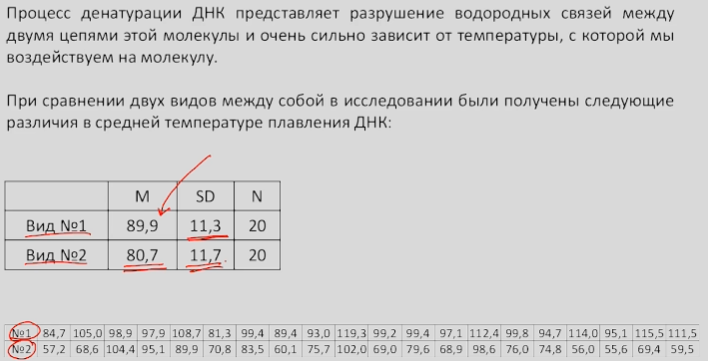

Гипотезы: <br>
$H_0: M_1 = M_2$ - ничего нового <br>
$H_1: M_1 \neq M_2$ - ценно

In [ ]:
m = (89.9, 80.7)
sd = (11.3, 11.7)
n = 20
se = np.sqrt(sd[0] ** 2 / n + sd[1] ** 2 / n); print('se = %.1f' % se)
t = (m[0] - m[1]) / se; print('t = %.1f' % t)
df = n + n - 2
p_value_student(t, df) #stats.t.sf(np.abs(t), df) * 2

se = 3.6
t = 2.5


0.0156935300771004

**Визуализация данных**

Плохой пример - нет меры изменчивость, нет подписей:


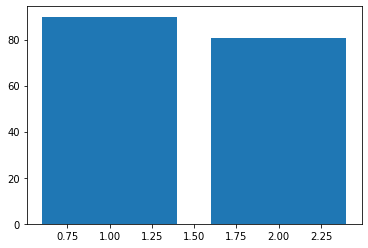

In [ ]:
plt.bar([1,2], m);
print('Плохой пример - нет меры изменчивость, нет подписей:')

**График с доверительными интервалами:**

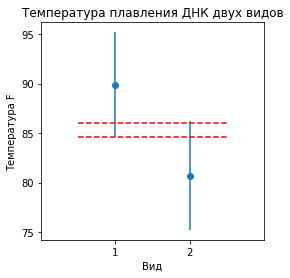

In [ ]:
k = stats.t.ppf(0.975, 20-1)
err1 = k * sd[0] / n ** 0.5
err2 = k * sd[1] / n ** 0.5
err = (err1, err2)
plt.figure(figsize=(4,4))
plt.errorbar([1,2], m, yerr=err, fmt = 'o')
plt.title('Температура плавления ДНК двух видов')
plt.xlabel('Вид'); plt.ylabel('Температура F')
plt.xticks((1, 2)); plt.yticks(np.arange(75,100,5))
plt.xlim(0, 3)
plt.plot([.5,2.5], [m[0]-err1]*2, '--r')
plt.plot([.5,2.5], [m[1]+err1]*2, '--r');

Дисперсии должны быть примерно одинаковы (гомогенность дисперсий) <br>
Тесты:
*   Левена
*   Фишера <br>
Если объем выборок < 30, важно чтобы распределение было нормальным



In [ ]:
np.random.seed(0)
data1 = 5 * np.random.randn(100) + 50
data2 = 5 * np.random.randn(100) + 51

stats.levene(data1, data2)

LeveneResult(statistic=0.8044068777603481, pvalue=0.37086823781213485)

https://stackoverflow.com/questions/21494141/how-do-i-do-a-f-test-in-python

In [ ]:
F = data1.std(ddof=1) / data2.std(ddof=1)
df1, df2 = len(data1) - 1, len(data2) - 1
p = stats.f.cdf(F, df1, df2)
p

0.44822262734813967

In [ ]:
stats.f_oneway(data1, data2)

F_onewayResult(statistic=2.342895527322163, pvalue=0.12745152487986014)

**Задача**

Рассчитайте доверительный интервал основываясь на знании t - распределения для среднего значения температуры плавления ДНК у первого вида:

$\bar{X}=89,9\quad sd=11,3\quad n=20 $

Для этого определите, в каком диапазоне находится 95 % наблюдений у соответствующего t - распределения (df = n -1) и используйте это значение вместо коэффициента 1,96. 

Давайте воспользуемся таблицей критических значений для t - распределения для нахождения нужного t - значения:

http://www.medcalc.org/manual/t-distribution.php

В этой таблице нас интересует столбец, где A=0,95 (область под кривой). На пересечении этого столбца и строки с нужным числом степеней свободы и находится интересующее нас значение.

**Ответ: [84.61; 95.19]**

In [ ]:
x_mean, sd, n, p = 89.9, 11.3, 20, 0.95
df = n - 1
k = stats.t.ppf(0.975, df)
se = sd / np.sqrt(n)
x_mean - k * se, x_mean + k * se

(84.61143720745503, 95.18856279254499)

Функция scipy:

In [ ]:
stats.ttest_ind(data1, data2)

Ttest_indResult(statistic=-1.5306519941914007, pvalue=0.1274515248798618)

И вручную, сверим:

In [ ]:
m = (data1.mean(), data2.mean())
sd = (data1.std(ddof=1), data2.std(ddof=1))
n = 100
se = np.sqrt(sd[0] ** 2 / n + sd[1] ** 2 / n); print('se = %.1f' % se)
t = (m[0] - m[1]) / se; print('t = %.2f' % t)
df = n + n - 2
p_value_student(t, df) #stats.t.sf(np.abs(t), df) * 2

se = 0.7
t = -1.53


0.1274515248798618

Если есть выбросы => U-критерий Манна-Уитни (п. 2.3.)

### 2.3. Проверка распределения на нормальность, QQ-Plot

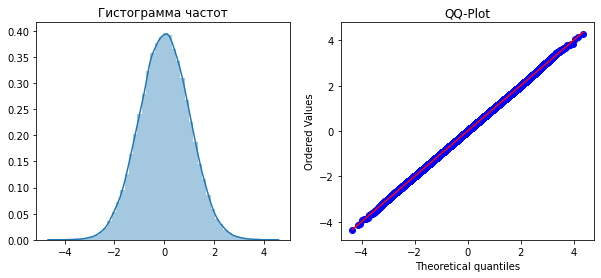

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.distplot(normal); plt.title('Гистограмма частот')
plt.subplot(122)
stats.probplot(normal, dist="norm", plot=plt); plt.title('QQ-Plot');

Проверка распредлеения на нормальность:
*   Колмогорова-Смирнова
*   Шапиро-Вилк

$H_0$ - распределение данных значимо не отличается от нормального 

$H_1$ - отличается

p < 0.05 означает плохую новость.

В данном случае желания отклонять H0 нет!

In [ ]:
w, p = stats.shapiro(normal)
p

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.46033796668052673

In [ ]:
w, p = stats.kstest(normal, 'norm')
p # тест Колмогорова-Смирнова

0.005137960447461039

Важно проверять распределение на нормальность, т.к. выбросы могут оказать значительное влияние на результаты t-теста<br>
Непараметрический U-критерий Манна -Уитни не столь чувствителен к наличию выбросов по сравнению с t-тестом <br>
Критерий переводит все данные в ранговую шкалу<br>

*H.B. Mann and D.R. Whitney, “On a Test of Whether one of Two Random Variables is Stochastically Larger than the Other,” The Annals of Mathematical Statistics, vol. 18, no. 1, pp. 50-60, 1947.*

In [ ]:
stats.ttest_ind(data1, data2)

Ttest_indResult(statistic=-1.5306519941914007, pvalue=0.1274515248798618)

In [ ]:
stats.mannwhitneyu(data1, data2)

MannwhitneyuResult(statistic=4489.0, pvalue=0.10613459079388066)

### 2.4. Однофакторный дисперсионный анализ

Три группы измерений:

In [ ]:
a = np.array([3, 1, 2])
b = np.array([5, 3, 4])
c = np.array([7, 6, 5])
m = 3 # три группы

Гипотезы:<br>
$H_0: M_1 = M_2 = M_3$ <br>
$H_1: M_1 \neq M_2 \neq M_3$ * <br>
\* - точнее: хотя бы пара средних отличается друг от друга <br>
Решение:<br>
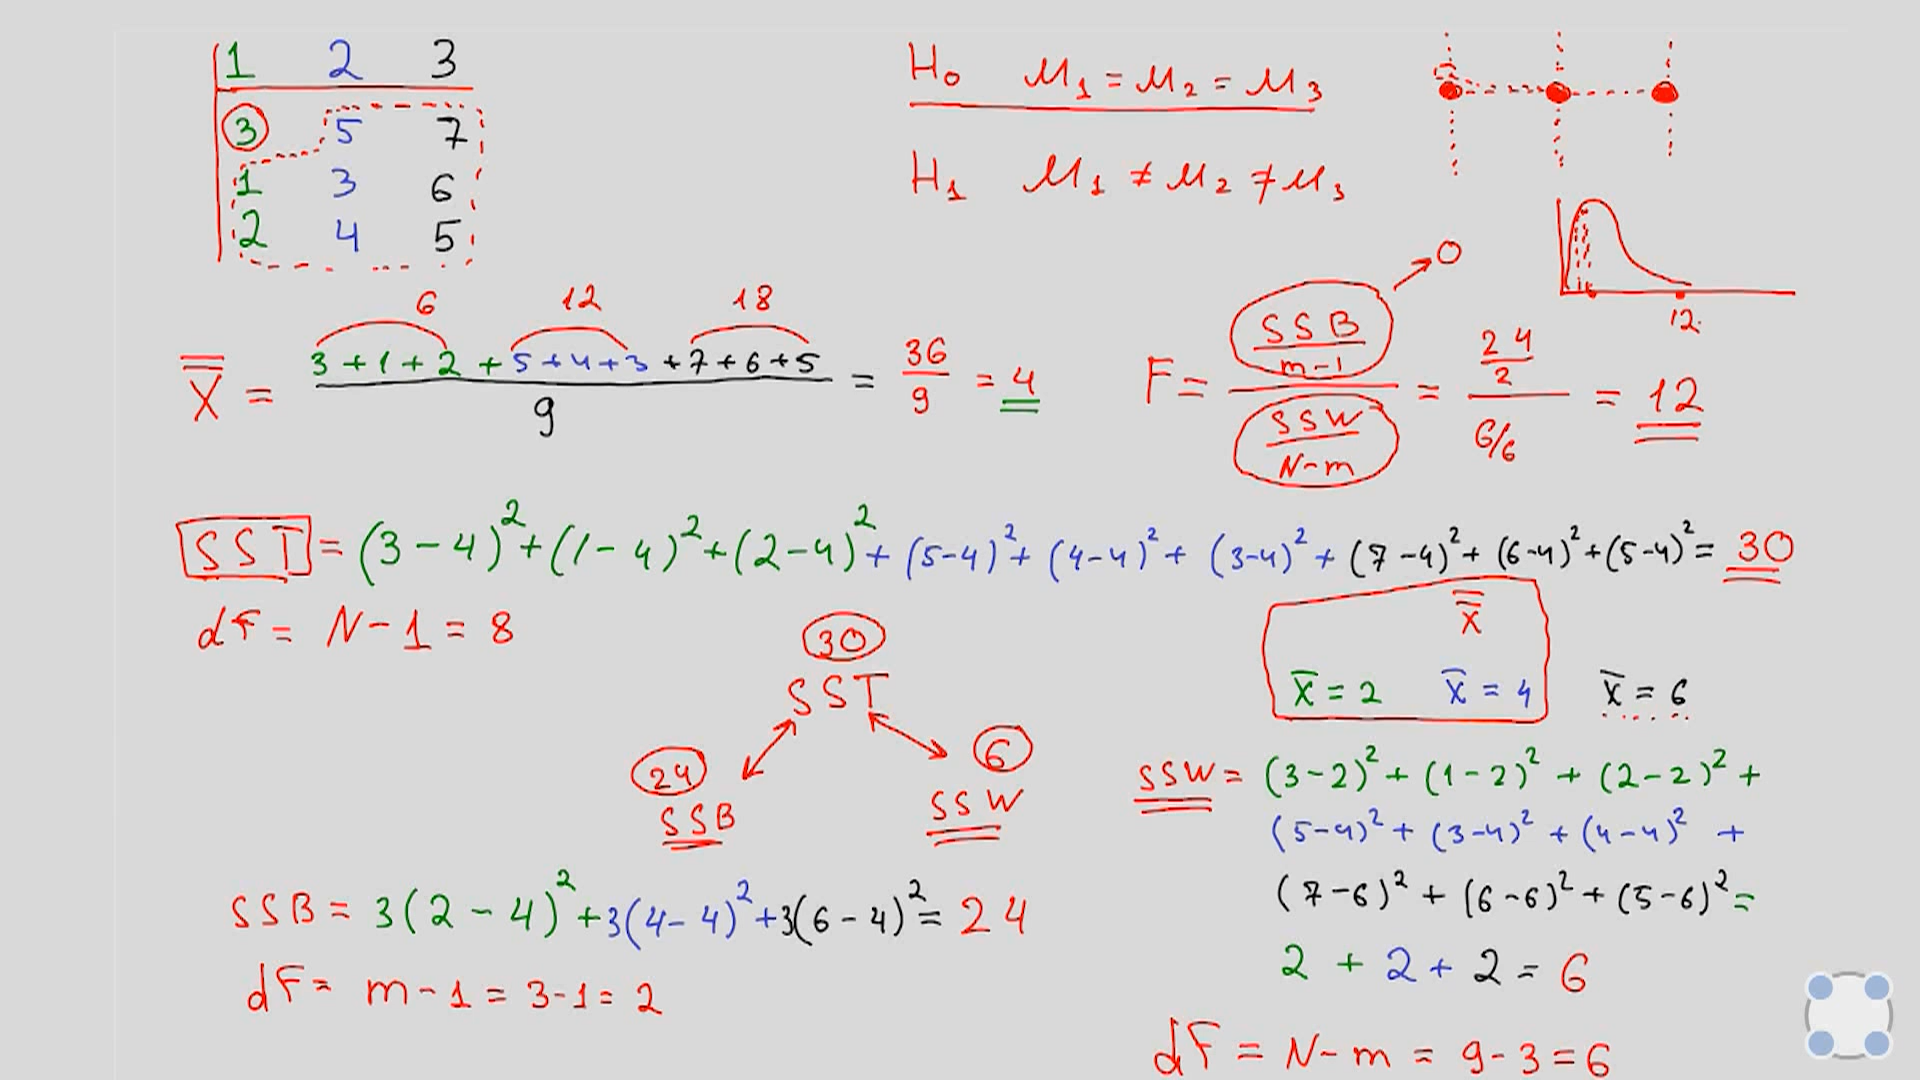

#### Расчет "вручную"

In [ ]:
x = np.concatenate((a, b, c))
x_mean = x.mean(); x_mean

4.0

SST - общая сумма квадратов (total sum squares) <br>
(без учета разделения на группы)

In [ ]:
sst = x.std() ** 2 * len(x)

N = len(x)
df = N - 1

sst, df

(30.0, 8)

SST:


*   SSB - сумма квадратов междгрупповая (sum square between groups)
*   SSW - сумма квадратов внутригрупповая (sum square within groups)



In [ ]:
a.mean(), b.mean(), c.mean()

(2.0, 4.0, 6.0)

In [ ]:
ssw = a.std() ** 2 * len(a) + b.std() ** 2 * len(b) + c.std() ** 2 * len(c)
df_ssw = N - m
ssw, df_ssw

(6.0, 6)

In [ ]:
ssb = np.array([a.mean(), b.mean(), c.mean()])
ssb = m * (ssb.std() ** 2) * m
df_ssb = m - 1
ssb, df_ssb

(24.0, 2)

In [ ]:
print('SST - %d: SSB - %d and SSW - %d' % (sst, ssb, ssw))
if ssb > ssw:
  print('ssb > ssw - группы значительно различаются между собой')
elif ssw > ssb:
  print('ssb < ssw - группы не различаются. Изменчивость обусловленна внутригрупповой изменчивостью')
else:
  print('ssw = ssb')

SST - 30: SSB - 24 and SSW - 6
ssb > ssw - группы значительно различаются между собой


In [ ]:
f = (ssb / (m-1)) / (ssw / (N-m))
print('f-критерий = ', f)

f-критерий =  12.0


In [ ]:
# односторонний критерий( f - всегда положительно)
print('%.5f' % stats.f.sf(f, dfn=m-1, dfd=N-m))

0.00800


#### Тоже самое одной строчкой:

In [ ]:
stats.f_oneway(a, b, c)

F_onewayResult(statistic=12.0, pvalue=0.008000000000000002)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Load iris data
iris = load_iris()

# Create features and target
X = iris.data
y = iris.target

# Create an SelectKBest object to select features with two best ANOVA F-Values
fvalue_selector = SelectKBest(f_classif, k=2)

# Apply the SelectKBest object to the features and target
X_kbest = fvalue_selector.fit_transform(X, y)

# Show results
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_kbest.shape[1])
print()
print('Было:', X[0])
print('Стало:', X_kbest[0])

Original number of features: 4
Reduced number of features: 2

Было: [5.1 3.5 1.4 0.2]
Стало: [1.4 0.2]


#### Распределение Фишера

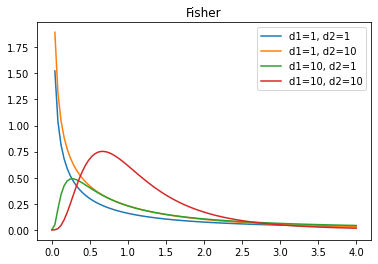

In [ ]:
plot_fisher(1, 1); plot_fisher(1, 10); plot_fisher(10, 1); plot_fisher(10, 10) 
# y = stats.f.pdf(x, dfn, dfd)

#### One-way ANOVA

In [ ]:
URL = 'https://stepik.org/media/attachments/lesson/8083/genetherapy.csv'
data = pd.read_csv(URL)
data.head()

,expr,Therapy
0,100,A
1,96,A
2,101,A
3,95,A
4,103,A


In [ ]:
data['expr'].groupby(data['Therapy']).agg(['mean', 'std', 'count']) 
# все по 15 шт, гомогенность дисперсий допустим есть (без Левена), 
# нормальность на 15 шт проверять сложно :)

,mean,std,count
Therapy,,,
A,99.733,4.166,15
B,98.800,5.894,15
C,94.400,5.193,15
D,92.333,3.735,15


Гипотезы:<br>
$H_0: M_1 = M_2 = M_3 = M_4$ <br>
$H_1: M_1 ≠ M_2 ≠ M_3 ≠ M_4$

Решение кратко:

In [ ]:
samples = [sample.tolist() for group, sample in data.groupby('Therapy')['expr']]
samples = np.array(samples)
stats.f_oneway(*samples)

F_onewayResult(statistic=8.03730248114399, pvalue=0.00015249722895229536)

Решение подробно:

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
print('Результаты дисперсионного анализа:')
mod = ols('expr~Therapy', data=data).fit()
anova_table = sm.stats.anova_lm(mod, typ=1)
print('Отклоняем Ho:')
print('Это значит, что как минимум два средних значимо отличаются между собой')
anova_table

Результаты дисперсионного анализа:
Отклоняем Ho:
Это значит, что как минимум два средних значимо отличаются между собой


,df,sum_sq,mean_sq,F,PR(>F)
Therapy,3.000,560.717,186.906,8.037,0.000
Residual,56.000,1302.267,23.255,nan,nan


df = m - 1| N-m <br>
Sum_Sq = SSB | SSW<br>
Mean_Sq = SSB / df | SSW / df<br>
F = SSB/df / SSW/df

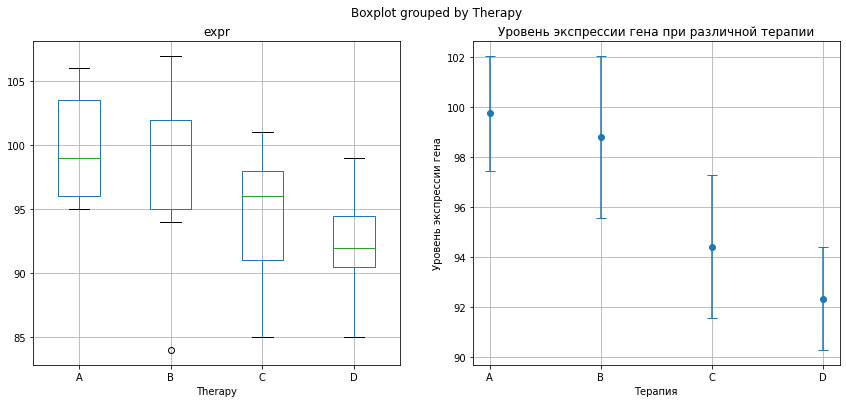

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
#subplot 121
data.boxplot('expr', by='Therapy', grid=True, ax=axes[0]); plt.title('Уровень экспрессии гена при различной терапии'); plt.ylabel('Уровень экспрессии гена');
#subplot 122
k = stats.t.ppf(0.975, len(samples[0]))
dev = k * samples.std(ddof=1, axis=1) / len(samples[0]) ** 0.5
axes[1].errorbar(['A', 'B', 'C', 'D'], samples.mean(axis=1), yerr=dev,
                                                            fmt='o', capsize=5)
plt.grid(); plt.title('Уровень экспрессии гена при различной терапии'); plt.ylabel('Уровень экспрессии гена'); plt.xlabel('Терапия');

### 2.5. Множественные сравнения в ANOVA

**Поправка Бонферрони** — один из методов контроля групповой вероятности ошибки (первого рода), который утверждает, что для достижения уровня $\alpha$ достаточно, чтобы отвергались гипотезы $H_i$, для которых $p_i \le \alpha/m$, где $m$ — количество гипотез. <br>
Количество попарных сравнений - m = n·(n-1) / 2

Поправка важна - позволяет избежать ложных открытий (рано или поздно можно получить значимое различие там, где его нет). Однако, поправка сильно критикуется за ее сверх консервативность - настолько p-уровень значимости низок, что получить новые открытия порой нереально. Современная статистика вынужденна работать с большим объемом данных, для этого можно использовать менее консервативные методы, например **поправка Тьюкки**.

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B  -0.9333    0.9  -5.5961  3.7294  False
     A      C  -5.3333 0.0189  -9.9961 -0.6706   True
     A      D     -7.4  0.001 -12.0628 -2.7372   True
     B      C     -4.4 0.0712  -9.0628  0.2628  False
     B      D  -6.4667 0.0029 -11.1294 -1.8039   True
     C      D  -2.0667 0.6296  -6.7294  2.5961  False
-----------------------------------------------------


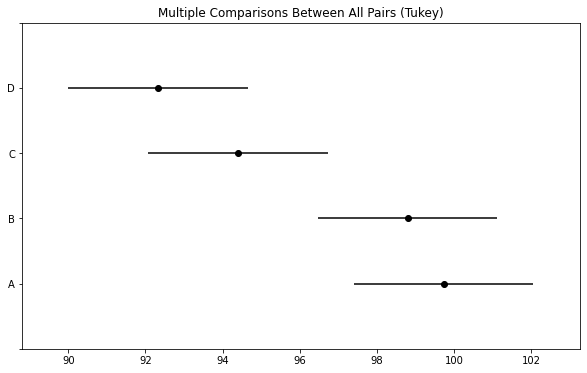

In [ ]:
from statsmodels.stats.multicomp import MultiComparison #, pairwise_tukeyhsd

MultiComp = MultiComparison(data['expr'], data['Therapy'])
results = MultiComp.tukeyhsd()
print(results.summary())
results.plot_simultaneous();
intervals = results.confint

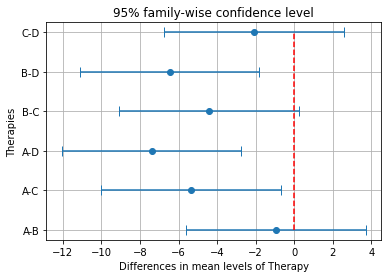

In [ ]:
plt.errorbar(intervals.mean(axis=1), ['A-B', 'A-C', 'A-D', 'B-C', 'B-D', 'C-D'],
             xerr=intervals[:,1]-intervals.mean(axis=1), capsize=5, fmt='o'); plt.grid(); plt.title('95% family-wise confidence level'); plt.ylabel('Therapies'); plt.xlabel('Differences in mean levels of Therapy');
plt.plot([0,0], [0,5], '--r');

### 2.6. Многофакторный ANOVA

#### Датасет 'atherosclerosis.csv'

In [ ]:
data = pd.read_csv("https://stepik.org/media/attachments/lesson/9250/atherosclerosis.csv")
data.head()

,expr,age,dose
0,107.351,1,D1
1,104.504,1,D1
2,103.435,1,D1
3,109.573,1,D1
4,114.994,1,D1


In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
data.groupby(['age', 'dose']).agg(('count','mean','std'))

expr              
         count    mean   std
age dose                    
1   D1      16 104.758 5.863
    D2      16 105.546 4.369
2   D1      16 101.005 5.116
    D2      16 102.274 5.135

$SS_{total} = SSW + SSB_A + SSB_B + SSB_A · SSB_B$

In [ ]:
print('Результаты дисперсионного анализа:')
mod = ols('expr~dose+age+dose:age', data=data).fit()
anova_table = sm.stats.anova_lm(mod, typ=1); anova_table

Результаты дисперсионного анализа:


,df,sum_sq,mean_sq,F,PR(>F)
dose,1.000,16.912,16.912,0.638,0.428
age,1.000,197.453,197.453,7.450,0.008
dose:age,1.000,0.927,0.927,0.035,0.852
Residual,60.000,1590.257,26.504,nan,nan


In [ ]:
#Аналитическое решение (не мое) - разобрано, все верно:
#Степени свободы
N =  len(data['expr'])
m1 = len(data['age'].unique())
m2 = len(data['dose'].unique())
df_a = m1 - 1
df_b = m2 - 1
df_axb = df_a * df_b 
df_w = N - m1*m2

#Общее среднее
grand_mean = data['expr'].mean()

#Суммы квадратов
ssq_a = sum([(data[data.age ==i].expr.mean()-grand_mean)**2 for i in data.age])
ssq_b = sum([(data[data.dose ==i].expr.mean()-grand_mean)**2 for i in data.dose])
ssq_t = sum((data.expr - grand_mean)**2)
spl_age=[data[data.age == i] for i in data.age.unique()]
age_means=[[x_age[x_age.dose == d].expr.mean() for d in x_age.dose] for x_age in spl_age]
ssq_w = sum([sum((spl_age[i].expr-age_means[i])**2) for i in range(len(data.age.unique()))])
ssq_axb = ssq_t-ssq_a-ssq_b-ssq_w
#Средние квадраты
ms_a = ssq_a/df_a
ms_b = ssq_b/df_b
ms_axb = ssq_axb/df_axb
ms_w = ssq_w/df_w
#F-значения
f_a = ms_a/ms_w
f_b = ms_b/ms_w
f_axb = ms_axb/ms_w
#P-значения
p_a = stats.f.sf(f_a, df_a, df_w)
p_b = stats.f.sf(f_b, df_b, df_w)
p_axb = stats.f.sf(f_axb, df_axb, df_w)
#результаты
results = {'sum_sq':[ssq_a, ssq_b, ssq_axb, ssq_w],
           'df':[df_a, df_b, df_axb, df_w],
           'F':[f_a, f_b, f_axb, 'NaN'],
            'PR(>F)':[p_a, p_b, p_axb, 'NaN']}
columns=['sum_sq', 'df', 'F', 'PR(>F)']
aov_table1 = pd.DataFrame(results, columns=columns,
                          index=['age', 'dose', 
                          'age:dose', 'Residual'])
aov_table1

           sum_sq  df     F PR(>F)
age       197.453   1 7.450  0.008
dose       16.912   1 0.638  0.428
age:dose    0.927   1 0.035  0.852
Residual 1590.257  60   NaN    NaN


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Дозировка не значима, возраст - значим


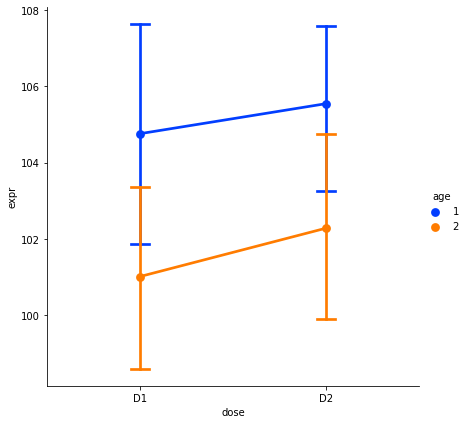

In [ ]:
#from statsmodels.graphics.factorplots import interaction_plot
#interaction_plot(data['dose'], data['age'], data['expr'], 
#                 colors=['green','red'], markers=['D','^'], ms=10);
sns.factorplot(x="dose", y="expr", hue="age", data=data,
                   palette="bright",capsize=.1, height=6);
print('Дозировка не значима, возраст - значим')

#### Датасет 'birds.csv'

In [ ]:
data = pd.read_csv('https://stepik.org/media/attachments/lesson/9250/birds.csv')
data.head()

,var4,hormone,sex
0,17.859,1,1
1,20.842,1,1
2,19.318,1,1
3,20.064,1,1
4,17.620,1,1


In [ ]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

formula = 'var4 ~ hormone + sex + hormone:sex'
model = ols(formula, data).fit()
anova_table = sm.stats.anova_lm(model, typ=1)
print(anova_table)

                df  sum_sq  mean_sq     F  PR(>F)
hormone      1.000   0.847    0.847 0.087   0.770
sex          1.000   0.120    0.120 0.012   0.912
hormone:sex  1.000  89.483   89.483 9.136   0.004
Residual    60.000 587.650    9.794   nan     nan


Ни инъекция гармона ни пол не влияют на концентрацию кальция в плазме крови у птиц.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Значимо их взаимодействие!!!
Обычно не более 2х факторов (редко 3). Анализ и визуализация сложны


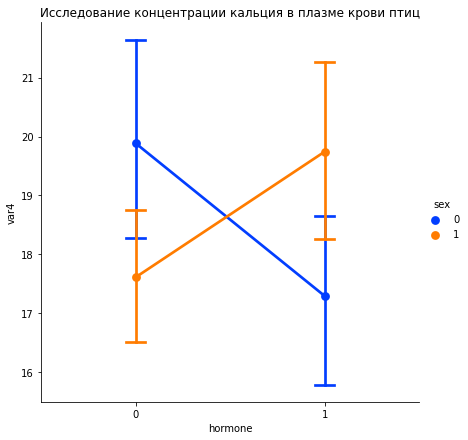

In [ ]:
sns.factorplot(x="hormone", y="var4", hue="sex", data=data,
                   palette="bright",capsize=.1, height=6); plt.title("Исследование концентрации кальция в плазме крови птиц")
print('Значимо их взаимодействие!!!')
print('Обычно не более 2х факторов (редко 3). Анализ и визуализация сложны')

### Итог по дисперсионному анализу

Требования к данным для дисперсионного анализа:


1.   Нормальность распределения (QQ-plot, тест Шапиро-Вилка)
2.   Гомогенность дисперсий (boxplot, тест Левена)

При большом количестве наблюдений (>50), ANOVA устойчива к нарушениям этих условий.

ANOVA не говорит о причинно-следственной зависимости: математики лучше разбираются в статистике нежели филологи. Однако, кто занимается математикой, лучше знают статистику, но и те кто изучают статистику, становятся математиками.

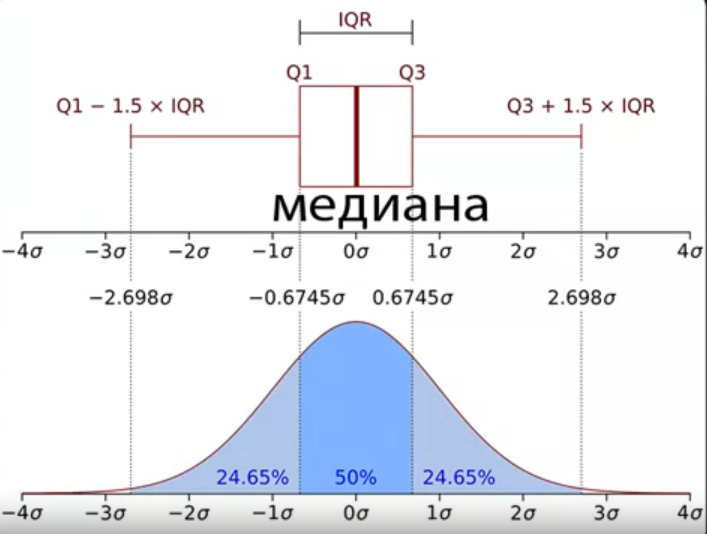

## 3. Корреляция и регрессия

### 3.1. Понятие корреляции

Положительная взаимосвязь - r > 0

Отрицательная - r < 0

Корреляция не обязательно говорит о причинно-следственной связи. Она не обязательно ее означает, но может означать.

In [ ]:
n = 100
h = np.random.randint(160, 191, n)
w = 22 * h ** 2 / 1e4 + np.random.randint(-8, 8, n) # через ИМТ=22

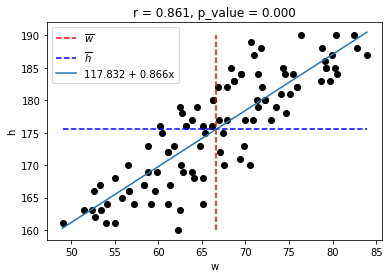

In [ ]:
#plot.scatter(x, y, c='k')
#lr = LinearRegression().fit(x.reshape((-1, 1)), y)
#r, p_value = stats.pearsonr(x, y)
plot_corr(w, h, 'w', 'h') # plot_corr(x, y, x_label='x', y_label='y', plot=plt):

Положительная корреляция. Большинство данных находятся с левом-нижнем и правом-верхнем квадратах
$(X_i-\overline{X})·(Y_i-\overline{Y})>0$

$cov = \frac{(X_i-\overline{X})·(Y_i-\overline{Y})}{N-1}$

$r_{XY} = \frac{cov}{\sigma_X·\sigma_Y}$ - масштабируем ковариацию в промежуток от -1 до 1

Сократим N-1, получим:
$$r_{xy} = \frac{∑(x_i-\overline{X})(y_i-\overline{Y})}{\sqrt{∑(x_i-\overline{X})^2∑(y_i-\overline{Y})^2}}$$

$D = r^2$ - коэф. детерминации. Показатель, который демонстрирует в какой степени дисперсия одной переменной обусловлена взаимосвязью с другой переменной. На сколько процентов X U Y.

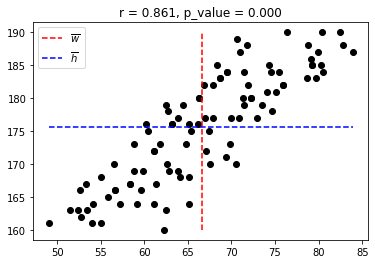

In [ ]:
plot_corr(w, h, 'w', 'h')

$H_0: r_{XY} = 0$

$H_1: r_{XY} \neq 0$

df = N - 2

t - значение -> p-value

In [ ]:
r, p_value = stats.pearsonr(w, h)
print(r, p_value)

dist = stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
p = 2*dist.cdf(-abs(r)); p

0.8611218778482099 1.5020253455248577e-30


1.5020253455248577e-30

### 3.2. Условия применения коэффициента корреляции

Только для линейной связи, причем монтонной! 

Желательно, чтобы x и y были нормально распределены (это связано со значением среднего в формуле)

Опасность выбросов(!) :

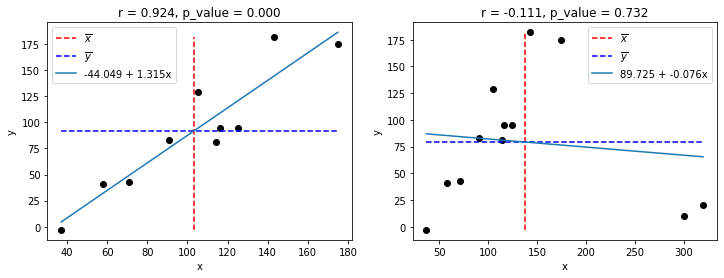

In [ ]:
x2 = np.array([37, 58, 71, 91, 105, 114, 116, 125, 143, 175])
y2 = np.array([-3, 41, 43, 83, 129, 81, 95, 95, 182, 175])
x = np.concatenate((x2, [300, 320])) 
y = np.concatenate((y2, [10, 20]))
n = len(x)

plt.figure(figsize=(12, 4))
plt.subplot(121); plot_corr(x2, y2)
plt.subplot(122); plot_corr(x, y)

Для выбросов:

Параметрический -> Непараметрический ранжированный

Если - T-критерий -> Критерий Манна-Уитни

То - Коэф. корр. Пирсона -> Коэф. корр. Спирмена и тау Кендалла

Коэффициент корреляции Спирмена
$r_s = 1 - \frac{6\sum\limits_{i=1}^Nd_i^2}{N(N^2-1)}$ 

In [ ]:
data = pd.DataFrame({'x':x, 'y':y})
data['rank_x'] = data['x'].rank()
data['rank_y'] = data['y'].rank()
data['d2'] = (data['rank_x'] - data['rank_y']) ** 2
data

,x,y,rank_x,rank_y,d2
0,37,-3,1.000,1.000,0.000
1,58,41,2.000,4.000,4.000
2,71,43,3.000,5.000,4.000
3,91,83,4.000,7.000,9.000
4,105,129,5.000,10.000,25.000
5,114,81,6.000,6.000,0.000
6,116,95,7.000,8.500,2.250
7,125,95,8.000,8.500,0.250
8,143,182,9.000,12.000,9.000
9,175,175,10.000,11.000,1.000


r-Спирмена = 0.24300699300699302


SpearmanrResult(correlation=0.24168163157672948, pvalue=0.4491887440384277)

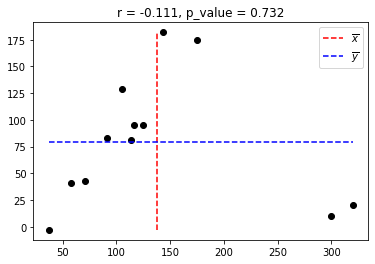

In [ ]:
plot_corr(data['x'], data['y'])
rs = 1 - 6 * data['d2'].sum() / (n * (n **2 - 1))
print('r-Спирмена =', rs)
stats.spearmanr(x, y)

In [ ]:
data[['x', 'y']].corr()

,x,y
x,1.000,-0.111
y,-0.111,1.000


In [ ]:
data[['x', 'y']].corr('spearman')

,x,y
x,1.000,0.242
y,0.242,1.000


### 3.3. Регрессия с одной независимой переменной

**Линия регрессии**
$y = b_0 + b_1 x,  b_0 - intercept, b_1 - slope$

**МНК** - метод нахождения оптимальных параметров линейной регрессии, таких, что сумма квадратов ошибок (остатков) была минимальна.

r2: 0.8542404049128032
r: 0.9242512671956707
intercept: -44.04923718436646
slope: [1.31545157]


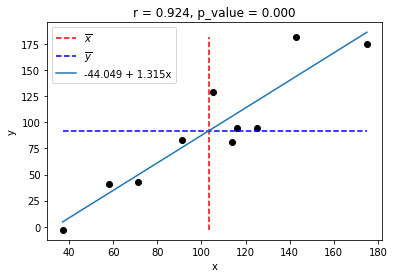

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(x2.reshape((-1, 1)), y2)
r2 = lr.score(x2.reshape((-1, 1)), y2)
print('r2:', r2)
print('r:', r2 ** 0.5)
print('intercept:', lr.intercept_)
print('slope:', lr.coef_)

plot_corr(x2, y2)
#y_th = lr.intercept_ + lr.coef_[0] * x_th

МНК - метод нахождения оптимальных параметров ($b_1$ и $b_2$) линейной регрессии, таких, что сумма квадратов ошибок (остатков) была минимальна

$b_1 = \frac{sd_y}{sd_x}r_{xy}$

$b_0 = \overline Y - b_1 * \overline X$

$\hat y = b_0 + b_1 x$

### 3.4. Гипотеза о значимости взаимосвязи и коэффициент детерминации

$r_{xy}=0 \Rightarrow b_1=0, b_0=\overline Y, \hat Y = \overline Y $

$H_0: b_1 = 0$

$H_1: b_1 \neq 0$

$t = \frac {b_1 - 0}{se} = \frac{b_1}{se}, df=N-2$, распределение Стьюдента

$R^2$ - доля дисперсии зависимой переменной(Y), объясняемая регресионной моделью

$R^2 = 1 - \frac {ss_{res}}{ss_{total}}$ 

$ss_{res}$ - сумма квадратов расст. от наблюдения до рергессионной прямой, $ss_{total}$ - сумма квадратов расст. от наблюдения до $\overline Y$

### 3.5. Условия применения линейной регрессии с одним предиктором

Условия применения:


1.   Линейнвя взаимосвязь X и Y
2.   Нормальное распределение
3.   Гомоскедастичность - постоянная изменчивость остатков на всех уровнях независимой переменной

https://gallery.shinyapps.io/slr_diag/



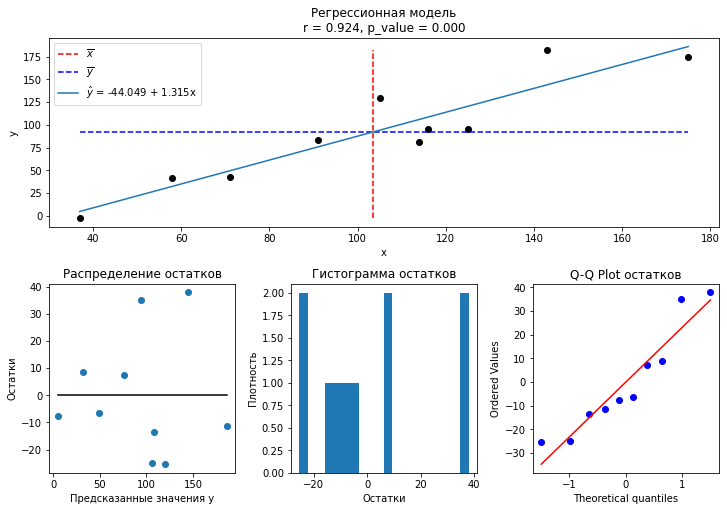

In [ ]:
plot_full_corr(x2, y2) #, residuals_by_y=False)

С увеличением х - увеличивается диспресия у и коэф. корреляции маленький. При этом остатки распределены нормально:

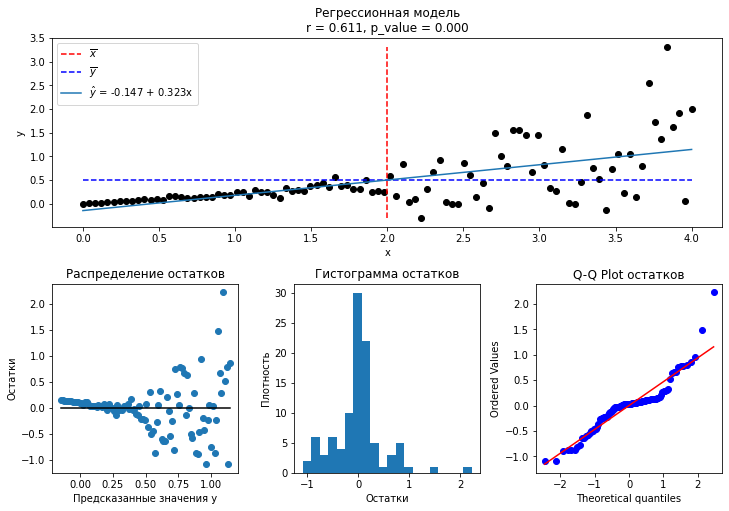

In [ ]:
x = np.linspace(0, 4, 100)
y = x * 0.2 + np.random.randn(100) * x ** 2 / 16
plot_full_corr(x, y)

Наблюдается ГЕТЕРОскедастичность, это плохо.

Проверим **Критерий Бройша-Пагана**:

$H_0: \mathbb D \epsilon = \sigma ^2$

$H_1: H_0$ неверна

Статистика: $LM = n R^2_{\hat{\epsilon}^2}$ - коэффициент детерминации при реграссии $\hat{\epsilon}^2$ на $x$

Нулевое распределение: $LM \sim \chi ^2 _k$


In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.formula.api import ols
data_xy = pd.DataFrame({'x':x, 'y':y})
formula = 'y ~ x'
model = ols(formula=formula, data=data_xy).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     58.25
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           1.53e-11
Time:                        19:25:02   Log-Likelihood:                -70.254
No. Observations:                 100   AIC:                             144.5
Df Residuals:                      98   BIC:                             149.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1470      0.098     -1.500      0.1

In [ ]:
print('Residuals:')
print(model.resid[:5], model.resid.shape) #residuals
print()
print('Exog:')
print(model.model.exog[:4])
print()
print('x:')
print(data_xy.x.values[:4])

Residuals:
0    0.146961
1    0.141969
2    0.136628
3    0.131306
4    0.126768
dtype: float64 (100,)

Exog:
[[1.         0.        ]
 [1.         0.04040404]
 [1.         0.08080808]
 [1.         0.12121212]]

x:
[0.         0.04040404 0.08080808 0.12121212]


In [ ]:
bp_test = het_breuschpagan(model.resid, model.model.exog)
print('lm_statistic, lm_pvalue, fvalue, f_pvalue')
print(bp_test)

lm_statistic, lm_pvalue, fvalue, f_pvalue
(20.815886493569025, 5.056181322213037e-06, 25.762198830502633, 1.836869257082047e-06)


lm_pvalue = 5e-06, гипотеза $H_0$ отвергается

Ошибки гетероскедастичны, значит, значимость признаков может определяться неверно. Сделаем поправку Уайта (менее точна, но устойчиво к гетероскедастичности):

In [ ]:
model = ols(formula=formula, data=data_xy).fit(cov_type='HC1')
#HC1 - гетероскедастичность, 
# 1 - номер поправки (их несколько, какая лучше не известно, 
# можно всегда использовать 1)
print('Все также, но дисперсии чуть меньше:')
print(model.summary())

Все также, но дисперсии чуть меньше:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     37.28
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           2.06e-08
Time:                        19:36:44   Log-Likelihood:                -70.254
No. Observations:                 100   AIC:                             144.5
Df Residuals:                      98   BIC:                             149.7
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -

### 3.6. Применение регрессионного анализа и интерпретация результатов

In [ ]:
data = pd.read_csv('https://stepik.org/media/attachments/lesson/8086/states.csv')
data.head()

,state,metro_res,white,hs_grad,poverty,female_house
0,Alabama,55.400,71.300,79.900,14.600,14.200
1,Alaska,65.600,70.800,90.600,8.300,10.800
2,Arizona,88.200,87.700,83.800,13.300,11.100
3,Arkansas,52.500,81.000,80.900,18.000,12.100
4,California,94.400,77.500,81.100,12.800,12.600


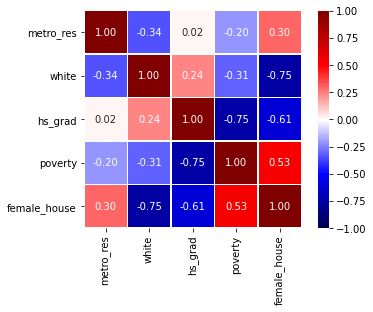

In [ ]:
sns.heatmap(data.corr(), vmax=1, vmin=-1, center=0, cmap='seismic',
          square=True, linewidths=.5, annot=True, fmt=".2f");

Регресионный анализ с одной независимой переменной:
1. $\hat Y = b_0 + b_1 x$
2. $R^2$ <br>
$H_0: b_1 = 0$ <br>
$H_1: b_1 \neq 0$
3. Pred: НП -> ЗП

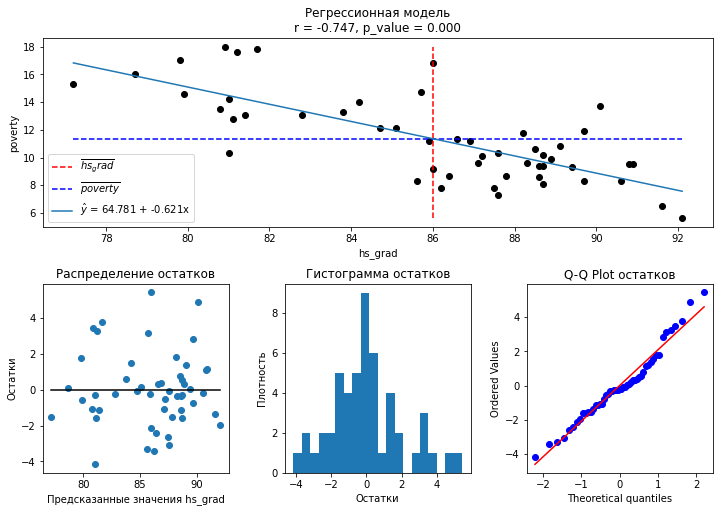

In [ ]:
plot_full_corr(data['hs_grad'].values, data['poverty'].values, 
               'hs_grad', 'poverty', False)

Судя по остаткам - применение регрессионного анализа: **обосновано**.

In [ ]:
stats.linregress(data['hs_grad'].values, data['poverty'].values)

LinregressResult(slope=-0.6212167177940106, intercept=64.78096577010209, rvalue=-0.7468582531582505, pvalue=3.10882981031841e-10, stderr=0.0790164710017928)

In [ ]:
import statsmodels.formula.api as smf
smf.ols('poverty ~ hs_grad', data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                poverty   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     61.81
Date:                Sat, 30 May 2020   Prob (F-statistic):           3.11e-10
Time:                        22:19:53   Log-Likelihood:                -108.74
No. Observations:                  51   AIC:                             221.5
Df Residuals:                      49   BIC:                             225.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     64.7810      6.803      9.523      0.000      51.111      78.451
hs_grad       -0.6212      0.079     -7.862      0.000      -0.780      -0.462
==============================================================================
Omnibus:                        3.534   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.171   Jarque-Bera (JB):                2.653
Skew:                           0.540   Prob(JB):                        0.265
Kurtosis:                       3.289   Cond. No.                     2.01e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# лучше использовать принт, тогда оформляется в виде таблицы-отчета
print(smf.ols('poverty ~ hs_grad', data=data).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                poverty   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     61.81
Date:                Sun, 31 May 2020   Prob (F-statistic):           3.11e-10
Time:                        00:33:55   Log-Likelihood:                -108.74
No. Observations:                  51   AIC:                             221.5
Df Residuals:                      49   BIC:                             225.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     64.7810      6.803      9.523      0.0

**Смысл $b_1$.** С каждым процентом увеличения кол-ва людей, имеющих среднее образование, на 1%, мы ожидаем, что кол-во людей, проживающих в бедности будет уменьшаться на 0,62 % ($b_1$).

**$R^2$** - 56% изменчивости зависимой переменной объясняется моделью.

### 3.7. Задача предсказания значений зависимой переменной

Задача проста: зная Х по регрессионной прямой определить Y.

*Например: какой будет % бедности в штате, где уровень образования 95%?*

**Важно**: не забывать о лимитах. Например, *уровень образования не может быть 101%*

**Лайфхак**: в качестве независимой переменной можно использовать **время** и смотреть: как зависимая переменная зависит от времени.

### 3.8. Регрессионный анализ с несколькими независимыми переменными

$\hat y = b_0 + b_1x_1+b_2x_2+...+b_nx_n$

*Например: для двух независимых переменных строится не регрессионная прямая, а плоскость*

**Требования к данным:**


1.   Линейная зависимость переменных
2.   Нормальное распределение остатков
3.   Гетероскедастичность
4.   Проверка на мультиколлинеарность
5.   Нормальеное распределеьение переменных (желательно)



In [ ]:
data.head(3)

,state,metro_res,white,hs_grad,poverty,female_house
0,Alabama,55.400,71.300,79.900,14.600,14.200
1,Alaska,65.600,70.800,90.600,8.300,10.800
2,Arizona,88.200,87.700,83.800,13.300,11.100


In [ ]:
print(smf.ols('poverty ~ hs_grad + white + metro_res + female_house',
                                          data=data).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                poverty   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     20.58
Date:                Sun, 31 May 2020   Prob (F-statistic):           8.88e-10
Time:                        00:32:59   Log-Likelihood:                -103.39
No. Observations:                  51   AIC:                             216.8
Df Residuals:                      46   BIC:                             226.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       66.4765     12.590      5.280   

При **НЕизменении** других переменных, если увеличить на 1% людей, проживающих в столичной области, количество бедных людей сократится на 0.06%.

Регрессия позволяет посмотреть зависимость **по отдельности** каждой независимой переменной и зависимой (остальные переменные **зафиксированы**). *Например, если зависимая переменная - интеллект, а независимые - размер ноги и возраст, то коэффициент перед переменной "размер ноги" будет близок к нулю, а для возраста значительно больше.*

Здесь также рассчитывается и **исправленный R2**. Множественные сравнения - чем больше переменных, тем R2 больше. Но это не потому, что они взаимосвязанны с зависимой переменной, а потому, как рано или поздно будет поймана **случайная связь** между предкиторами и зависимой переменной.

### 3.9. Выбор наилучшей модели

Если независимые переменные взаимосвязаны - достаточно только одной из них, иначе модель будет **менее** точна.

,metro_res,white,hs_grad,poverty,female_house
metro_res,1.000,-0.342,0.018,-0.204,0.300
white,-0.342,1.000,0.238,-0.309,-0.751
hs_grad,0.018,0.238,1.000,-0.747,-0.612
poverty,-0.204,-0.309,-0.747,1.000,0.525
female_house,0.300,-0.751,-0.612,0.525,1.000


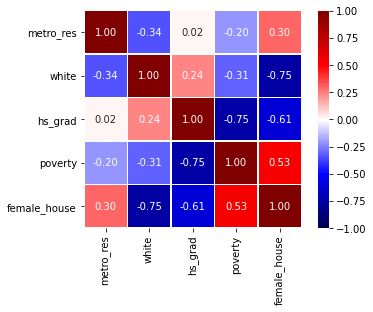

In [ ]:
sns.heatmap(data.corr(), vmax=1, vmin=-1, center=0, cmap='seismic',
          square=True, linewidths=.5, annot=True, fmt=".2f")
data.corr()          

female_house - очень сильно коррелируют с другими независимыми переменными. Может она ухудшает качество модели? Подберем модель!

In [ ]:
print('Шаг 1. Удалим 1 переменную из модели и выберем лучшую:')
# rsquared_adj = smf.ols(model, data=data).fit().rsquared_adj
calc_rsquared_adj('poverty ~ hs_grad + white + metro_res + female_house', data)
calc_rsquared_adj('poverty ~ hs_grad + white + metro_res', data)
calc_rsquared_adj('poverty ~ hs_grad + white + female_house', data)
calc_rsquared_adj('poverty ~ hs_grad + metro_res + female_house', data)
calc_rsquared_adj('poverty ~ white + metro_res + female_house', data)
print()
print('Лучшая модель (ожидаемо, согласно корр. м/у независ. перем.):')
calc_rsquared_adj('poverty ~ hs_grad + white + metro_res', data);

Шаг 1. Удалим 1 переменную из модели и выберем лучшую:
poverty ~ hs_grad + white + metro_res + female_house: r2_adj = 0.6104
poverty ~ hs_grad + white + metro_res: r2_adj = 0.6183
poverty ~ hs_grad + white + female_house: r2_adj = 0.5499
poverty ~ hs_grad + metro_res + female_house: r2_adj = 0.6011
poverty ~ white + metro_res + female_house: r2_adj = 0.3869

Лучшая модель (ожидаемо, согласно корр. м/у независ. перем.):
poverty ~ hs_grad + white + metro_res: r2_adj = 0.6183


In [ ]:
print('Шаг 2. Удалим снова у лучшей модели 1го шага:')
calc_rsquared_adj('poverty ~ hs_grad + white + metro_res', data)
calc_rsquared_adj('poverty ~ hs_grad + white', data)
calc_rsquared_adj('poverty ~ hs_grad + metro_res', data)
calc_rsquared_adj('poverty ~ white + metro_res', data)
print()
print('На шаге 2 результаты хуже шага 1.')
print('Есть основания пологать, что модель 1го шага - лучшая:')
calc_rsquared_adj('poverty ~ hs_grad + white + metro_res', data);

Шаг 2. Удалим снова у лучшей модели 1го шага:
poverty ~ hs_grad + white + metro_res: r2_adj = 0.6183
poverty ~ hs_grad + white: r2_adj = 0.5582
poverty ~ hs_grad + metro_res: r2_adj = 0.5773
poverty ~ white + metro_res: r2_adj = 0.1708

На шаге 2 результаты хуже шага 1.
Есть основания пологать, что модель 1го шага - лучшая:
poverty ~ hs_grad + white + metro_res: r2_adj = 0.6183


In [ ]:
print('Итоговая модель:')
model = 'poverty ~ hs_grad + white + metro_res'
print(smf.ols(model, data=data).fit().summary())

Итоговая модель:
                            OLS Regression Results                            
Dep. Variable:                poverty   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     28.00
Date:                Sun, 31 May 2020   Prob (F-statistic):           1.55e-10
Time:                        01:09:33   Log-Likelihood:                -103.41
No. Observations:                  51   AIC:                             214.8
Df Residuals:                      47   BIC:                             222.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     68.7220      6.389   

Подытожим: количество не значит качество (убираем взаимосвязанные независимые переменные)





### Заключение

Еще раз необходимо уловить отличие.

**Регрессионный анализ** - набор статистических методов исследования влияния одной или нескольких независимых переменных на зависимую.

**Дисперсионный анализ** - метод в математической статистике, направленный на поиск зависимостей в экспериментальных данных путем исследования значимости различий в средних значениях.

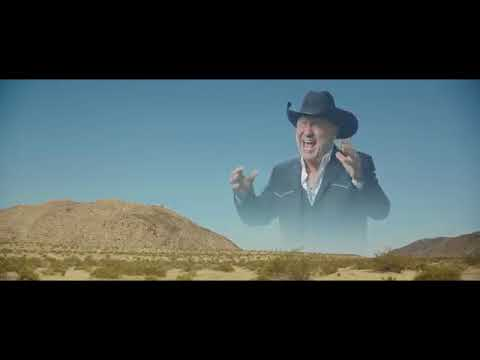

In [ ]:
from IPython.display import display, HTML
# HTML('<iframe width="560" height="315" src="https://www.youtube.com/watch?v=yBLdQ1a4-JI" frameborder="0" allowfullscreen></iframe>')
display(HTML(u"<h3><font color='green'>P.S. когда освоил основы статистики:</font></h3>"))   # также <h2>, <h3>

from IPython.lib.display import YouTubeVideo
YouTubeVideo('yBLdQ1a4-JI')